# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Project Index

 - [Imports & Read Files](#imports)
 - [Defining constants](#constants)
 - [Cleaning and Transforming Data](#cleaning)
 - [Understading behaviour with examples](#understading)
 - [Data View](#view)
 - [Discovery](#discovery)
 - [Discussion](#discussion)
 - [Segmenting Custormer by offer suggested](#groups)
 - [Business Decision](#decisions)


<a name="imports"></a>
### Imports & Read Files
--- 
Importing Libraries and reading raw data offered by Starbucks in json format

**FIRST UPDATE LIBRARIES**

Terminal > Run the commands below

~~~
pip install sklearn
pip install -U scikit-learn
~~~

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import r2_score, confusion_matrix, plot_confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler, OneHotEncoder
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

<a name="constants"></a>
### Defining constants
--- 
Defining constants to be used in this notebook.

In [2]:
EVENT_TYPES = list(transcript.event.unique())

In [3]:
OFFERS_IDS = list(portfolio['id'])

In [4]:
OFFER_TYPES = list(portfolio['offer_type'].unique())

In [5]:
channels_types = []
for group_channels in list(portfolio.channels):
    for channel in group_channels:
        if channel not in channels_types:
            channels_types.append(channel)
CHANNELS_TYPES = channels_types

In [6]:
# Checking the input keys in the transcript value
# Obs: both 'offer_id' and 'offer id' are the same. Made checks, and they never happen at same time.
dict_keys_types = []
for row in transcript['value']:
    for key in list(row.keys()):
        if key not in dict_keys_types:
            dict_keys_types.append(key)
dict_keys_types.remove('offer id')
DICT_KEYS_TYPES = dict_keys_types

<a name="cleaning"></a>
### Cleaning and Transforming Data
---
This section contains the data treatment before any analysis.

In [7]:
def clean_portfolio(portfolio=portfolio):
    ''' Data Cleaning for portfolio
    INPUT - portfolio (Dataframe)
    OUTPUT - portfolio_clean (Dataframe)
    '''
    portifolio_clean = portfolio
    
    # Clean 01: Unesting Channels
    for each_channel in CHANNELS_TYPES:
        portifolio_clean['channel_' + each_channel] = portifolio_clean['channels'].apply(lambda x: 1 if each_channel in x else 0)
        
    return(portifolio_clean)

In [8]:
def clean_transcript(transcript=transcript):
    ''' Data Cleaning for transcript
    INPUT - transcript (Dataframe)
    OUTPUT - transcript_clean (Dataframe)
    '''
    transcript_clean = transcript
    
    
    # Clean 01: Unesting Keys of transcript
    # Obs: both 'offer_id' and 'offer id' are the same. Made checks, and they never happen at same time.
    transcript_clean['offer_id'] = transcript_clean['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else x['offer id'] if 'offer id' in x else None)
    for each_key in ['amount','reward']:
        transcript_clean[each_key] = transcript_clean['value'].apply(lambda x: x[each_key] if each_key in x else None)
    
    
    # Clean 02: Atributing transactions to the offer
    # If the previous was an completed order, the next transaction gain it offer_id
    # If informational, after receive and view, the transaction should happen in the duration time
    transcript_clean = transcript
    mapping_event_order = {'offer received':1,'offer viewed':2, 'offer completed':3, 'transaction':4}
    transcript_clean['event_order'] = transcript_clean['event'].replace(mapping_event_order)
    transcript_clean = transcript_clean.merge(portfolio[['id','offer_type','duration']], how='left', left_on='offer_id', right_on='id') 
    transcript_clean = transcript_clean.sort_values(by=['person','time','event_order'])
    transcript_clean['offer_id_fix'] = transcript_clean['offer_id']

    current_offer = {'temp_person': 'no person',
                     'temp_offer_id': 'no offer',
                     'temp_offer_limit_time': -1,
                     'temp_validate_view': False,
                     'temp_last_was_completed':False}
    current_offer_reset = current_offer.copy()
    temp_offer_id_fix = []


    for index, row in transcript_clean[['event','person','offer_id','time','offer_type','duration']].iterrows():

        if row['person'] != current_offer['temp_person']:
            current_offer = current_offer_reset.copy()
            current_offer['temp_person'] = row['person']

        if row['offer_id'] is not None:

            if row['offer_type'] == 'informational':

                if row['event'] == 'offer received':
                    current_offer['temp_offer_id'] = row['offer_id']
                    current_offer['temp_offer_limit_time']  = row['time'] + 24*row['duration']
                    current_offer['temp_validate_view'] = False

                if row['event'] == 'offer viewed' and row['offer_id'] == current_offer['temp_offer_id']:
                    current_offer['temp_validate_view'] = True

            if row['event'] == 'offer completed':
                current_offer['temp_offer_id'] = row['offer_id']
                current_offer['temp_offer_limit_time']  = -1
                current_offer['temp_validate_view'] = False
                current_offer['temp_last_was_completed'] = True

        if current_offer['temp_offer_limit_time'] < row['time'] and not current_offer['temp_last_was_completed']:
            current_offer = current_offer_reset.copy()
            current_offer['temp_person'] = row['person']

        if row['event']=='transaction':
            if not current_offer['temp_validate_view'] and not current_offer['temp_last_was_completed']:
                current_offer['temp_offer_id'] = 'no offer'
            temp_offer_id_fix.append(current_offer['temp_offer_id'])
            current_offer = current_offer_reset.copy()
        else:
            temp_offer_id_fix.append(row['offer_id'])

    transcript_clean['offer_id_fix'] = temp_offer_id_fix
    transcript_clean = transcript_clean.drop(labels = ['id','offer_type','duration','event_order'], axis = 1)
    
    
    # Clean 03: Creating the offer_version, which is an identifier to separate from same offer affecting the same user
    transcript_clean = transcript_clean.sort_values(by=['person','offer_id_fix','time'])
    offer_version = []
    temp_person = '0'
    temp_offer = '0'
    temp_version = 0
    for index, row in transcript_clean[['event','person','offer_id_fix']].iterrows():
        if row['offer_id_fix'] != temp_offer:
            temp_offer = row['offer_id_fix']
            temp_version = 0
        if row['person'] != temp_person:
            temp_person = row['person']
            temp_version = 0
        if row['event']=='offer received':
            temp_version = temp_version + 1
        offer_version.append(str(temp_version))
    transcript_clean['offer_version'] = offer_version
    
    
    # Clean 04: Creating unique index to identify user_offer_version
    transcript_clean['id_user_offer'] = transcript_clean['person'] + '_' + transcript_clean['offer_id_fix'] + '_' + transcript_clean['offer_version']
    
    
    return(transcript_clean)

In [9]:
def clean_profile(profile=profile):
    ''' Data Cleaning for profile
    INPUT - profile (Dataframe)
    OUTPUT - profile_clean (Dataframe)
    '''
    profile_clean = profile
    
    # Clean 01: Data transformation of time (YYYYMMDD - int) to time (YYYYMMDD - Timestamp)
    profile_clean['became_member_on'] = profile_clean['became_member_on'].apply(lambda x: datetime.strptime(str(x), '%Y%m%d'))
    
    # Clean 02: Data transformation of time (YYYYMMDD) to days from current time
    # Obs: I am assuming the current time as the most recent date from became_member_on
    most_recent_member_date = profile_clean['became_member_on'].max()
    profile_clean['days_as_member'] = (most_recent_member_date - profile_clean['became_member_on']).apply(lambda x: x.days)
    
    # Clean 03: Transforming null inputs into columns
    profile_clean['user_info_missing'] = profile_clean['age'].apply(lambda x: 1 if x == 118 else 0)
    
    # Clean 04: Removing age 118 to null
    profile_clean['age'] = profile_clean['age'].apply(lambda x: None if x == 118 else x)

    return(profile_clean)

In [10]:
def create_df_events(portfolio=portfolio, transcript=transcript, profile=profile):
    ''' Creates a single dataframe based on events (granular level of transcript) to make easier data exploration
    INPUT 
        - profile (Dataframe)
        - transcript (Dataframe)
        - profile (Dataframe)
    OUTPUT - df_events (Dataframe)
    '''
    df_events = transcript.merge(profile, how='left', left_on='person', right_on='id', suffixes=('_t', '_p')) 
    df_events = df_events.drop(labels = ['id','value'], axis = 1)
    df_events = df_events.merge(portfolio, how='left', left_on='offer_id_fix', right_on='id', suffixes=('_realized', '_expected')) 
    df_events = df_events.drop(labels = ['id','channels'], axis = 1)
    
    return(df_events)

In [11]:
def create_df_funnel(portfolio=portfolio, transcript=transcript, profile=profile):
    ''' The goal is to construct the funnel dataframe of campaigns. Granular level of each user-campaign targeted combination.
    INPUT 
        - profile (Dataframe)
        - transcript (Dataframe)
        - profile (Dataframe)
    OUTPUT - df_funnel
    '''
    transcript['1'] = 1.0
    
    df_funnel_received = transcript[transcript['event']=='offer received'][['id_user_offer','person','offer_id','offer_id_fix','offer_version','time','1']]
    df_funnel_received.columns = ['id_user_offer','person','offer_id','offer_id_fix','offer_version','time__offer_received','funnel__offer_received']
    
    df_funnel_viewed = transcript[transcript['event']=='offer viewed'][['id_user_offer','time','1']]
    df_funnel_viewed.columns = ['id_user_offer','time__offer_viewed','funnel__offer_viewed']
    
    df_funnel_completed = transcript[transcript['event']=='offer completed'][['id_user_offer','time','1','reward']]
    df_funnel_completed.columns = ['id_user_offer','time__offer_completed','funnel__offer_completed','reward_realized']
    
    df_funnel_transaction = transcript[transcript['event']=='transaction'][['id_user_offer','time','1','reward']]
    df_funnel_transaction.columns = ['id_user_offer','time__transaction','funnel__transaction','amount']
    
    
    df_funnel = pd.merge(df_funnel_received, df_funnel_viewed, how='left', on='id_user_offer')
    df_funnel = pd.merge(df_funnel, df_funnel_completed, how='left', on='id_user_offer')
    df_funnel = pd.merge(df_funnel, df_funnel_transaction, how='left', on='id_user_offer')
    
    for each in ['funnel__offer_received','funnel__offer_viewed','funnel__offer_completed','funnel__transaction']:
        df_funnel[each] = df_funnel[each].fillna(0)
    
    df_funnel['funnel__viewed_offer_completed'] = df_funnel['funnel__offer_viewed'] * df_funnel['funnel__offer_completed']
    df_funnel['funnel__viewed_transaction'] = df_funnel['funnel__offer_viewed'] * df_funnel['funnel__transaction']
    
    df_funnel = df_funnel[['id_user_offer','person','offer_id','offer_id_fix','offer_version',
                         'time__offer_received','time__offer_viewed','time__offer_completed','time__transaction',
                         'funnel__offer_received','funnel__offer_viewed','funnel__offer_completed','funnel__transaction',
                         'funnel__viewed_offer_completed','funnel__viewed_transaction','amount','reward_realized']]
    
    df_funnel = df_funnel.merge(portfolio, how='left', left_on='offer_id_fix', right_on='id', suffixes=('_realized', '_expected')) 
    df_funnel = df_funnel.drop(labels = ['id'], axis = 1)
    df_funnel = df_funnel.merge(profile, how='left', left_on='person', right_on='id', suffixes=('_t', '_p')) 
    df_funnel = df_funnel.drop(labels = ['id'], axis = 1)
    
    return df_funnel

In [12]:
# Data Cleaning
portfolio = clean_portfolio(portfolio=portfolio)
transcript = clean_transcript(transcript=transcript)
profile = clean_profile(profile=profile)

# Data Creation
df_events = create_df_events(portfolio=portfolio, transcript=transcript, profile=profile)
df_funnel = create_df_funnel(portfolio=portfolio, transcript=transcript, profile=profile)

<a name="view"></a>
### Data View
---
Viewing the data after the cleaning and the theirs formats.

In [13]:
print('The portfolio  has {} rows\t and has {} columns'.format(portfolio.shape[1] ,portfolio.shape[0] ))
print('The profile    has {} rows\t and has {} columns'.format(profile.shape[1]   ,profile.shape[0]   ))
print('The transcript has {} rows\t and has {} columns'.format(transcript.shape[1],transcript.shape[0]))

The portfolio  has 10 rows	 and has 10 columns
The profile    has 7 rows	 and has 17000 columns
The transcript has 11 rows	 and has 306534 columns


In [14]:
profile.head(5)

,age,became_member_on,gender,id,income,days_as_member,user_info_missing
0,NaN,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN,529,1
1,55.0,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,376,0
2,NaN,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN,14,1
3,75.0,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,443,0
4,NaN,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN,356,1


In [15]:
transcript.head(5)

,event,person,time,value,offer_id,amount,reward,offer_id_fix,offer_version,id_user_offer,1
247879,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,1,0009655768c64bdeb2e877511632db8f_2906b810c7d44...,1.0
258884,offer completed,0009655768c64bdeb2e877511632db8f,576,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,1,0009655768c64bdeb2e877511632db8f_2906b810c7d44...,1.0
258883,transaction,0009655768c64bdeb2e877511632db8f,576,{'amount': 10.27},None,10.27,NaN,2906b810c7d4411798c6938adc9daaa5,1,0009655768c64bdeb2e877511632db8f_2906b810c7d44...,1.0
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed,1,0009655768c64bdeb2e877511632db8f_3f207df678b14...,1.0
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed,1,0009655768c64bdeb2e877511632db8f_3f207df678b14...,1.0


In [16]:
portfolio #Full since is only 10 rows

,channels,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1


<a name="understading"></a>
### Understading behaviour with examples
---
This section is to understand how the sequence of events occur in the dataset.

 - Ex.01. User that completed a BOGO offer (user_id = '676506bad68e4161b9bbaffeb039626b')
   - Obs.01.1 The user can be enrolled in more than 1 campaign at the same time, with both of them active. (dataframe index:201605,245158)
   - Obs.01.2 The offer can be received, viewed and completed in the same hour
   - Obs.01.3 A completed offer can not be used again.
  

 - Ex.02. User that completed a Discount offer (user_id = '9fa9ae8f57894cc9a3b8a9bbe0fc1b2f')
   - Obs.02.01 The discount offer events work in the same way as a Bogo Offer.


- Ex.03. User that received a Informational campaign and had an transaction (user_id = 'fe97aa22dd3e48c8b143116a8403dd52')
  - Obs.03.1 The informational campaigns does not compute the completition event, even happening transactions in the active campaign.
  - Obs.03.2 The same offer can target the same user multiple times while active. This behaviour may be because informational offer reset after the view event. 
  - Obs.03.2 The reward form informational campaigns is 0.


- Ex.04. Multiple offer completition at the same transaction
  - Obs.04.1 A single transaction can trigger the completition of multiple campaigns. We will take care on using the model atribution for the last campaign to the hole transaction.


- All. From all the use cases above
  - obs.all.01 The transaction events does not contain the offer_id. If a offer is completed, the information on the offer is then input there.
  - obs.all.02 The event offer completed happens at the same time of the transaction that included the discount.
  - obs.all.03 The amount seens to be the what the client actualy paid
  - obs.all.04 The reward_realized is the discount that the client received for that campaign. It only happens on the completed event.

In [17]:
example_columns = ['person','time','event','offer_id','offer_id_fix','offer_type','amount','reward_realized','reward_expected','difficulty','duration']

In [18]:
# Ex.01. User that completed a BOGO offer
df_events[df_events['person']=='676506bad68e4161b9bbaffeb039626b'][example_columns]

,person,time,event,offer_id,offer_id_fix,offer_type,amount,reward_realized,reward_expected,difficulty,duration
123373,676506bad68e4161b9bbaffeb039626b,504,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,NaN,NaN,5.0,20.0,10.0
123374,676506bad68e4161b9bbaffeb039626b,576,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,NaN,NaN,5.0,5.0,7.0
123375,676506bad68e4161b9bbaffeb039626b,588,offer viewed,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,NaN,NaN,5.0,5.0,7.0
123376,676506bad68e4161b9bbaffeb039626b,636,offer completed,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,NaN,5.0,5.0,5.0,7.0
123377,676506bad68e4161b9bbaffeb039626b,636,transaction,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,17.20,NaN,5.0,5.0,7.0
123378,676506bad68e4161b9bbaffeb039626b,0,offer received,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN,NaN,10.0,10.0,7.0
123379,676506bad68e4161b9bbaffeb039626b,0,offer viewed,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN,NaN,10.0,10.0,7.0
123380,676506bad68e4161b9bbaffeb039626b,0,offer completed,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd,bogo,NaN,10.0,10.0,10.0,7.0
123381,676506bad68e4161b9bbaffeb039626b,0,transaction,None,ae264e3637204a6fb9bb56bc8210ddfd,bogo,18.01,NaN,10.0,10.0,7.0
123382,676506bad68e4161b9bbaffeb039626b,36,transaction,None,no offer,NaN,36.75,NaN,NaN,NaN,NaN


In [19]:
# Ex.02. User that completed a Discount offer
df_events[df_events['person']=='9fa9ae8f57894cc9a3b8a9bbe0fc1b2f'][example_columns]

,person,time,event,offer_id,offer_id_fix,offer_type,amount,reward_realized,reward_expected,difficulty,duration
192199,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,408,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,NaN,NaN,5.0,20.0,10.0
192200,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,462,offer viewed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,NaN,NaN,5.0,20.0,10.0
192201,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,offer completed,0b1e1539f2cc45b7b9fa7c272da2e1d7,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,NaN,5.0,5.0,20.0,10.0
192202,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,474,transaction,None,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,21.13,NaN,5.0,20.0,10.0
192203,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,336,offer received,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,NaN,NaN,3.0,7.0,7.0
192204,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,342,offer viewed,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,NaN,NaN,3.0,7.0,7.0
192205,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,offer completed,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,NaN,3.0,3.0,7.0,7.0
192206,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,354,transaction,None,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,18.42,NaN,3.0,7.0,7.0
192207,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,offer received,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,discount,NaN,NaN,2.0,10.0,7.0
192208,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,offer viewed,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,discount,NaN,NaN,2.0,10.0,7.0


In [20]:
# Ex.03. User that received a Informational campaign and had an transaction
df_events[df_events['person']=='fe97aa22dd3e48c8b143116a8403dd52'][example_columns]

,person,time,event,offer_id,offer_id_fix,offer_type,amount,reward_realized,reward_expected,difficulty,duration
304884,fe97aa22dd3e48c8b143116a8403dd52,168,offer received,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304885,fe97aa22dd3e48c8b143116a8403dd52,198,offer viewed,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304886,fe97aa22dd3e48c8b143116a8403dd52,198,transaction,None,3f207df678b143eea3cee63160fa8bed,informational,28.71,NaN,0.0,0.0,4.0
304887,fe97aa22dd3e48c8b143116a8403dd52,504,offer received,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304888,fe97aa22dd3e48c8b143116a8403dd52,504,offer viewed,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304889,fe97aa22dd3e48c8b143116a8403dd52,576,offer received,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304890,fe97aa22dd3e48c8b143116a8403dd52,624,offer viewed,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,informational,NaN,NaN,0.0,0.0,4.0
304891,fe97aa22dd3e48c8b143116a8403dd52,624,transaction,None,3f207df678b143eea3cee63160fa8bed,informational,14.77,NaN,0.0,0.0,4.0
304892,fe97aa22dd3e48c8b143116a8403dd52,408,offer received,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,informational,NaN,NaN,0.0,0.0,3.0
304893,fe97aa22dd3e48c8b143116a8403dd52,420,offer viewed,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,informational,NaN,NaN,0.0,0.0,3.0


In [21]:
# Ex.04. Multiple offer completition at the same transaction
df_events[df_events['person']=='0011e0d4e6b944f998e987f904e8c1e5'].sort_values(by='time')

,event,person,time,offer_id,amount,reward_realized,offer_id_fix,offer_version,id_user_offer,age,...,days_as_member,user_info_missing,difficulty,duration,offer_type,reward_expected,channel_email,channel_mobile,channel_social,channel_web
34,offer received,0011e0d4e6b944f998e987f904e8c1e5,0,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed,1,0011e0d4e6b944f998e987f904e8c1e5_3f207df678b14...,40.0,...,198,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
35,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,6,3f207df678b143eea3cee63160fa8bed,NaN,NaN,3f207df678b143eea3cee63160fa8bed,1,0011e0d4e6b944f998e987f904e8c1e5_3f207df678b14...,40.0,...,198,0,0.0,4.0,informational,0.0,1.0,1.0,0.0,1.0
42,transaction,0011e0d4e6b944f998e987f904e8c1e5,132,None,13.49,NaN,no offer,0,0011e0d4e6b944f998e987f904e8c1e5_no offer_0,40.0,...,198,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,offer received,0011e0d4e6b944f998e987f904e8c1e5,168,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0011e0d4e6b944f998e987f904e8c1e5_2298d6c36e964...,40.0,...,198,0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
31,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,186,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0011e0d4e6b944f998e987f904e8c1e5_2298d6c36e964...,40.0,...,198,0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
32,offer completed,0011e0d4e6b944f998e987f904e8c1e5,252,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0011e0d4e6b944f998e987f904e8c1e5_2298d6c36e964...,40.0,...,198,0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
33,transaction,0011e0d4e6b944f998e987f904e8c1e5,252,None,11.93,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0011e0d4e6b944f998e987f904e8c1e5_2298d6c36e964...,40.0,...,198,0,7.0,7.0,discount,3.0,1.0,1.0,1.0,1.0
36,offer received,0011e0d4e6b944f998e987f904e8c1e5,336,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,1,0011e0d4e6b944f998e987f904e8c1e5_5a8bc65990b24...,40.0,...,198,0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
37,offer viewed,0011e0d4e6b944f998e987f904e8c1e5,354,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,1,0011e0d4e6b944f998e987f904e8c1e5_5a8bc65990b24...,40.0,...,198,0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
27,offer received,0011e0d4e6b944f998e987f904e8c1e5,408,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0011e0d4e6b944f998e987f904e8c1e5_0b1e1539f2cc4...,40.0,...,198,0,20.0,10.0,discount,5.0,1.0,0.0,0.0,1.0


<a name="discovery"></a>
### Discovery
---
Creating exploration questions to be asked to deepen the understanding of the situation.
 - [Q01.How many of the users receveid a offer?](#Q01)
 - [Q02.How many transactions are there? And how is the rate of transactions assisted by discounted offers](#Q02)
 - [Q03.How many hours of test do we have?](#Q03)
 - [Q04.How many offers were sent by type? And by campaign?](#Q04)
 - [Q05.How many offers were completed type? and by offer?](#Q05)
 - [Q06.How is the funnel performance by channel?](#Q06)
 - [Q07.How is the funnel performance by offer?](#Q07)
 

<a name="Q01"></a>
**Q01.How many of the users receveid a offer?**

 - There were 16994 users that received at least one offer in the dataset, from the 17000 unique users. A rate of 99.96%. 
 - This dataset does not have users without the influence of a promotion, ignoring the 6 outliers.
 - Any strategy to create a benchmarks of sales for non target users just became harder to make

In [22]:
q01_received = df_events[df_events['event']=='offer received'][['person']].drop_duplicates().count()[0]
q01_users = profile['id'].count()
q01_rate = 100 * q01_received / q01_users
print('This base has an {}% of users who received a offer. There were {} receives from {} users'.format(round(q01_rate,2),q01_received,q01_users))

This base has an 99.96% of users who received a offer. There were 16994 receives from 17000 users


<a name="Q02"></a>
**Q02.How many transactions are there? And how is the rate of assited by discounted offers**

 - There were 138.953 transactions on this dataset.
 - 24.2% of those are assisted with discount from a discount/BOGO offer.
 - An user make in average 8.2 transactions on the time period of the dataset
 - This dataset has a high amout of transaction per user, making analysisng by user more difficulty.

The amount of trasactions were 138953 with a total revenue of 1775451.9699999772, an 24.2% of those were assisted by a offer with discount
Average trasaction per user is 8.2


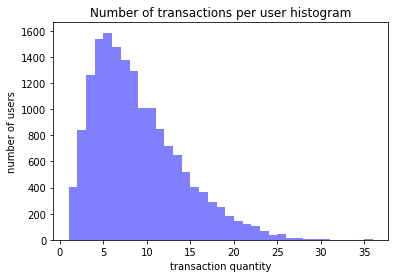

In [23]:
q02_reward = df_events[df_events['event']=='offer completed'].groupby(['offer_type']).agg({'reward_realized':['sum','count']}).reset_index()
q02_transactions = df_events[df_events['event']=='transaction'].groupby(['event']).agg({'amount':['sum','count']}).reset_index()
q02_assisted_rate = 100*q02_reward['reward_realized'].sum()['count']/q02_transactions['amount']['count'][0]
q02_users = df_events[df_events['event']=='offer received'][['person']].drop_duplicates().count()[0]
q02_trasaction_rate = q02_transactions['amount']['count'][0]/q02_users

print('The amount of trasactions were {} with a total revenue of {}, an {}% of those were assisted by a offer with discount'.format(
    str(q02_transactions['amount']['count'][0]),
    str(q02_transactions['amount']['sum'][0]),
    str(round(q02_assisted_rate,1))
))

print('Average trasaction per user is {}'.format(round(q02_trasaction_rate,1)))

q2_transactions_histogram = df_events[df_events['event']=='transaction'].groupby(['person'])['person'].count()
q2_bins = q2_transactions_histogram.max()-q2_transactions_histogram.min()
plt.title('Number of transactions per user histogram')
plt.hist(q2_transactions_histogram, bins=q2_bins, facecolor='blue', alpha=0.5)
plt.xlabel('transaction quantity')
plt.ylabel('number of users')
plt.show()

<a name="Q03"></a>
**Q03.How many hours of test do we have?**

 - Every offer been running for the same amount of time. 714 hours or 30 days.
 - The last offer was sent at 576 hours or 24 days. (basicaly 1 week of maturing)
 - The campaigns were sent at day 0, 7, 14, 17, 21 and 24. Each one sending about 12711 events, evenly distributed by each campaign.

In [24]:
for each_offer in OFFERS_IDS:
    q03_offer_hours = transcript[ transcript['offer_id'] == each_offer ]['time'].max()
    print('The offer: {} has been running for {} hours or {} days'.format(each_offer,q03_offer_hours,round(q03_offer_hours/24,0)))
    
q03_last_offer = transcript[transcript['event'] == 'offer received']['time'].max()
print('The last offer was sent at {} hours or {} days'.format(q03_last_offer,q03_last_offer/24))

The offer: ae264e3637204a6fb9bb56bc8210ddfd has been running for 714 hours or 30.0 days
The offer: 4d5c57ea9a6940dd891ad53e9dbe8da0 has been running for 714 hours or 30.0 days
The offer: 3f207df678b143eea3cee63160fa8bed has been running for 714 hours or 30.0 days
The offer: 9b98b8c7a33c4b65b9aebfe6a799e6d9 has been running for 714 hours or 30.0 days
The offer: 0b1e1539f2cc45b7b9fa7c272da2e1d7 has been running for 714 hours or 30.0 days
The offer: 2298d6c36e964ae4a3e7e9706d1fb8c2 has been running for 714 hours or 30.0 days
The offer: fafdcd668e3743c1bb461111dcafc2a4 has been running for 714 hours or 30.0 days
The offer: 5a8bc65990b245e5a138643cd4eb9837 has been running for 714 hours or 30.0 days
The offer: f19421c1d4aa40978ebb69ca19b0e20d has been running for 714 hours or 30.0 days
The offer: 2906b810c7d4411798c6938adc9daaa5 has been running for 714 hours or 30.0 days
The last offer was sent at 576 hours or 24.0 days


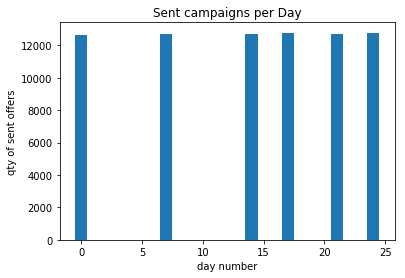

In [25]:
q03_offer_sent = transcript[transcript['event'] == 'offer received'].groupby(['time'])['event'].count().reset_index()
x = q03_offer_sent['time']/24
y = q03_offer_sent['event']
plt.bar(x,y, width=1)
plt.title('Sent campaigns per Day')
plt.xlabel('day number')
plt.ylabel('qty of sent offers')
plt.show()

<a name="Q04"></a>
**Q04.How many offers were sent by type? And by campaign?**

 - There were 30499 users targeted by offer bogo
 - There were 30543 users targeted by offer discount
 - There were 15235 users targeted by offer informational
 - Every offer was made ~7.600 times.

 There were 30499 users targeted by offer bogo
 There were 30543 users targeted by offer discount
 There were 15235 users targeted by offer informational


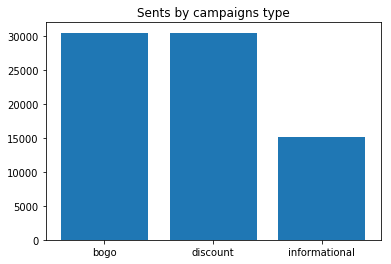

In [26]:
q04_offers_sent = df_events[df_events['event']=='offer received'].groupby(['offer_type'])['offer_id'].count().reset_index()
for each in q04_offers_sent.index:
    print(' There were {} users targeted by offer {}'.format(str(q04_offers_sent.iloc[each]['offer_id']),str(q04_offers_sent.iloc[each]['offer_type'])))
    
x = q04_offers_sent['offer_type']
y = q04_offers_sent['offer_id']
plt.bar(x,y, width=0.8)
plt.title('Sents by campaigns type')
plt.show()

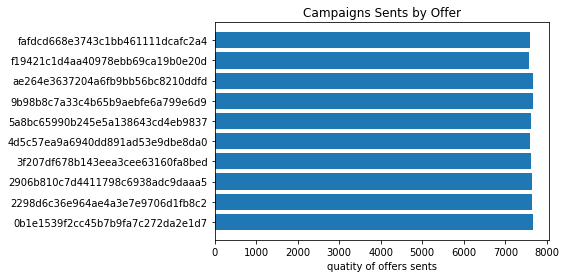

In [27]:
q04_received_by_offer = df_events[df_events['event']=='offer received'].groupby(['offer_id','offer_type'])[['event']].count().reset_index()

x = q04_received_by_offer['offer_id']
y = q04_received_by_offer['event']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('quatity of offers sents')
ax.set_title('Campaigns Sents by Offer')
plt.show()

<a name="Q05"></a>
**Q05.How many offers were completed type? and by offer?**
 - Offer type bogo has made a discount of 113440.00 with a total of 15669 uses and a average discount of 7.23
 - Offer type discount has made a discount of 51236.00 with a total of 17910 uses and a average discount of 2.86
 - The discounted/bogo offer range in completion from ~3300 to ~5300. This result mean that the type and dicount has an influence on the campaigns, or the campaigns are been user target already.
 - Both Informational types campaigns had the worst performance in terms of transactions and in terms of average tickets (Avg. amount). If they are benchmarks, we can see the increase in transactions of any offer that offers a reward. (One important notice is that informational offer has less time of duration)
 - The discount offer seems more efficienty, since it has more completition with less than half the budget of discount.

 Offer type bogo has made a discount of 113440.0 with a total of 15669 uses and a average discount of 7.239772799795775
 Offer type discount has made a discount of 51236.0 with a total of 17910 uses and a average discount of 2.860748185371301


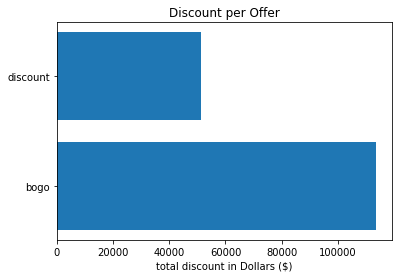

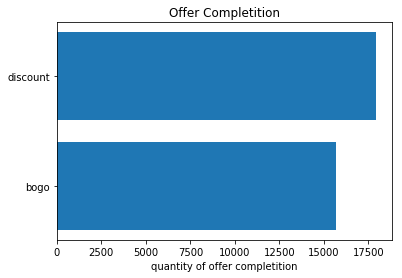

In [28]:
q05_reward = df_events[df_events['event']=='offer completed'].groupby(['offer_type']).agg({'reward_realized':['sum','count']}).reset_index()
for each in q05_reward.index:
    print(' Offer type {} has made a discount of {} with a total of {} uses and a average discount of {}'.format(
        str(q05_reward.loc[each]['offer_type'][0]),
        str(q05_reward.loc[each]['reward_realized']['sum']),
        str(q05_reward.loc[each]['reward_realized']['count']),
        str(q05_reward.loc[each]['reward_realized']['sum']/q05_reward.loc[each]['reward_realized']['count'])
    ))
    
x = q05_reward['offer_type']
y = q05_reward['reward_realized']['sum']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('total discount in Dollars ($)')
ax.set_title('Discount per Offer')
plt.show()

x = q05_reward['offer_type']
y = q05_reward['reward_realized']['count']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('quantity of offer completition')
ax.set_title('Offer Completition')
plt.show()

0b1e1539f2cc45b7b9fa7c272da2e1d7-discount made a discount of 17100.0 with a total of 3420 uses and a average discount of 5.0
2298d6c36e964ae4a3e7e9706d1fb8c2-discount made a discount of 15468.0 with a total of 5156 uses and a average discount of 3.0
2906b810c7d4411798c6938adc9daaa5-discount made a discount of 8034.0 with a total of 4017 uses and a average discount of 2.0
4d5c57ea9a6940dd891ad53e9dbe8da0-bogo made a discount of 33310.0 with a total of 3331 uses and a average discount of 10.0
9b98b8c7a33c4b65b9aebfe6a799e6d9-bogo made a discount of 21770.0 with a total of 4354 uses and a average discount of 5.0
ae264e3637204a6fb9bb56bc8210ddfd-bogo made a discount of 36880.0 with a total of 3688 uses and a average discount of 10.0
f19421c1d4aa40978ebb69ca19b0e20d-bogo made a discount of 21480.0 with a total of 4296 uses and a average discount of 5.0
fafdcd668e3743c1bb461111dcafc2a4-discount made a discount of 10634.0 with a total of 5317 uses and a average discount of 2.0


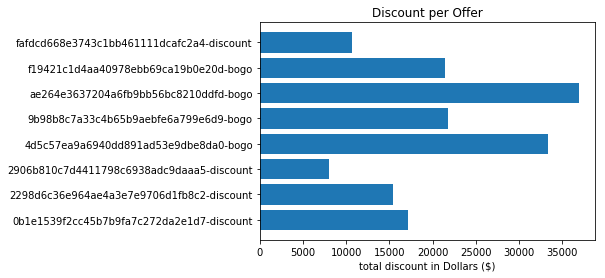

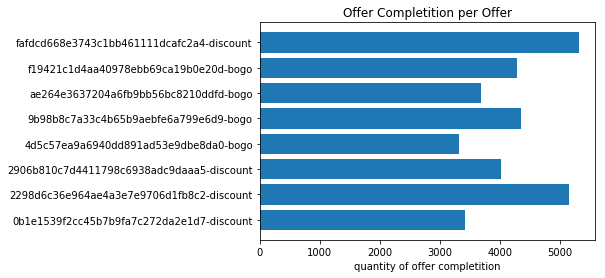

In [29]:
q05_df = df_events
q05_df['offer_id_type'] = q05_df['offer_id_fix'] + '-' + q05_df['offer_type']
q05_reward = q05_df[q05_df['event']=='offer completed'].groupby(['offer_id_type']).agg({'reward_realized':['sum','count']}).reset_index()
for each in q05_reward.index:
    print('{} made a discount of {} with a total of {} uses and a average discount of {}'.format(
        str(q05_reward.loc[each]['offer_id_type'][0]),
        str(q05_reward.loc[each]['reward_realized']['sum']),
        str(q05_reward.loc[each]['reward_realized']['count']),
        str(q05_reward.loc[each]['reward_realized']['sum']/q05_reward.loc[each]['reward_realized']['count'])
    ))

x = q05_reward['offer_id_type']
y = q05_reward['reward_realized']['sum']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('total discount in Dollars ($)')
ax.set_title('Discount per Offer')
plt.show()

x = q05_reward['offer_id_type']
y = q05_reward['reward_realized']['count']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('quantity of offer completition')
ax.set_title('Offer Completition per Offer')
plt.show()

Amount of 66865.01000000002 with 2669 transactions and a average ticket of 25.05 from 0b1e1539f2cc45b7b9fa7c272da2e1d7-discount
Amount of 84066.31999999972 with 4884 transactions and a average ticket of 17.21 from 2298d6c36e964ae4a3e7e9706d1fb8c2-discount
Amount of 73756.14999999966 with 3608 transactions and a average ticket of 20.44 from 2906b810c7d4411798c6938adc9daaa5-discount
Amount of 25530.000000000004 with 1713 transactions and a average ticket of 14.9 from 3f207df678b143eea3cee63160fa8bed-informational
Amount of 74174.47000000006 with 3141 transactions and a average ticket of 23.61 from 4d5c57ea9a6940dd891ad53e9dbe8da0-bogo
Amount of 35022.98000000009 with 2966 transactions and a average ticket of 11.81 from 5a8bc65990b245e5a138643cd4eb9837-informational
Amount of 70461.29000000011 with 3991 transactions and a average ticket of 17.66 from 9b98b8c7a33c4b65b9aebfe6a799e6d9-bogo
Amount of 80020.43999999989 with 3355 transactions and a average ticket of 23.85 from ae264e3637204a6f

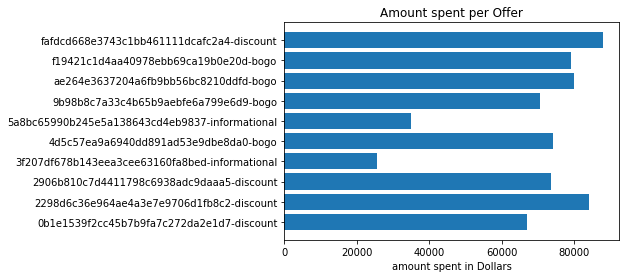

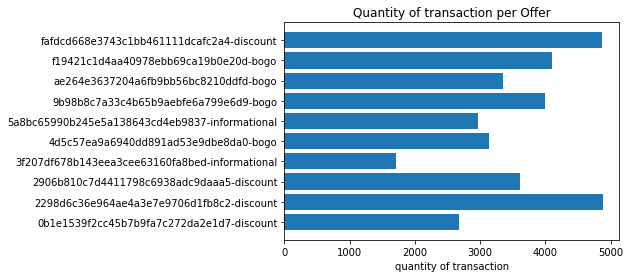

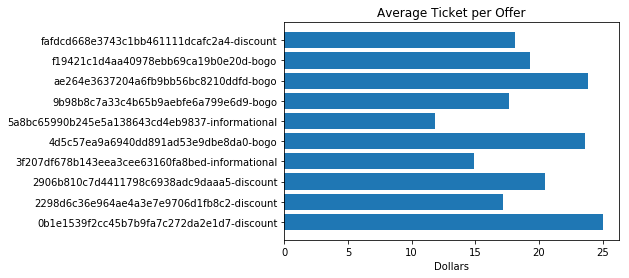

In [30]:
q05_df = df_events
q05_df['offer_id_type'] = q05_df['offer_id_fix'] + '-' + q05_df['offer_type']
q05_reward = q05_df[q05_df['event']=='transaction'].groupby(['offer_id_type']).agg({'amount':['sum','count']}).reset_index()
q05_reward['average_ticket'] = (q05_reward['amount']['sum']/q05_reward['amount']['count']).apply(lambda x: round(x,2))
for each in q05_reward.index:
    print('Amount of {} with {} transactions and a average ticket of {} from {}'.format(
        str(q05_reward.loc[each]['amount']['sum']),
        str(q05_reward.loc[each]['amount']['count']),
        str(q05_reward.loc[each]['average_ticket'][0]),
        str(q05_reward.loc[each]['offer_id_type'][0])
    ))

x = q05_reward['offer_id_type']
y = q05_reward['amount']['sum']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('amount spent in Dollars')
ax.set_title('Amount spent per Offer')
plt.show()

x = q05_reward['offer_id_type']
y = q05_reward['amount']['count']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('quantity of transaction')
ax.set_title('Quantity of transaction per Offer')
plt.show()

x = q05_reward['offer_id_type']
y = q05_reward['average_ticket']

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('Dollars')
ax.set_title('Average Ticket per Offer')
plt.show()

<a name="Q06"></a>
**Q06.How is the funnel performance by channel?**

 - The funnel performance from received to viewed seems to by dependent only by the channel selected. Obs: all number below are incredible similiar, so even with a low number of offers, we will extrapolate those. 
   - Using all four channels (email, mobile, social, web) the campaign has a view rate of ~96%
   - Using all except for web the rate goes to ~87%
   - Using all except for social the rate goes to ~54%
   - Using only e-mail and web the rate is ~35%, but this is only one campaign
 - Creating a small linear model we can see the influence of each variable. Obs: there is no training and testing, especialy beause of the volume of campaigns. So even with the 0.999 r2, this can be deceiveing. 
   - social = 42%
   - email = 26%
   - mobile = 19%
   - web = 8%
   

In [31]:
q06_df = df_funnel.copy()
q06_df['channels'] = df_funnel.channels.apply(lambda x: str(x))
q06_funnel_performance = q06_df.groupby(['offer_id','offer_type','channels','channel_email','channel_mobile','channel_social', 'channel_web'])[['funnel__offer_received','funnel__offer_viewed','funnel__offer_completed']].sum().reset_index()

q06_funnel_performance['received_to_viewed']    = q06_funnel_performance['funnel__offer_viewed']    / q06_funnel_performance['funnel__offer_received']
q06_funnel_performance['viewed_to_completed']   = q06_funnel_performance['funnel__offer_completed'] / q06_funnel_performance['funnel__offer_viewed']
q06_funnel_performance['received_to_completed'] = q06_funnel_performance['funnel__offer_completed'] / q06_funnel_performance['funnel__offer_received']

q06_funnel_performance = q06_funnel_performance.sort_values(by='received_to_viewed')
q06_funnel_performance[['offer_id','channels','received_to_viewed']]

,offer_id,channels,received_to_viewed
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,"['web', 'email']",0.349623
2,2906b810c7d4411798c6938adc9daaa5,"['web', 'email', 'mobile']",0.540996
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,"['web', 'email', 'mobile']",0.543608
3,3f207df678b143eea3cee63160fa8bed,"['web', 'email', 'mobile']",0.544046
7,ae264e3637204a6fb9bb56bc8210ddfd,"['email', 'mobile', 'social']",0.877059
5,5a8bc65990b245e5a138643cd4eb9837,"['email', 'mobile', 'social']",0.877789
1,2298d6c36e964ae4a3e7e9706d1fb8c2,"['web', 'email', 'mobile', 'social']",0.959316
8,f19421c1d4aa40978ebb69ca19b0e20d,"['web', 'email', 'mobile', 'social']",0.959632
4,4d5c57ea9a6940dd891ad53e9dbe8da0,"['web', 'email', 'mobile', 'social']",0.961039
9,fafdcd668e3743c1bb461111dcafc2a4,"['web', 'email', 'mobile', 'social']",0.964645


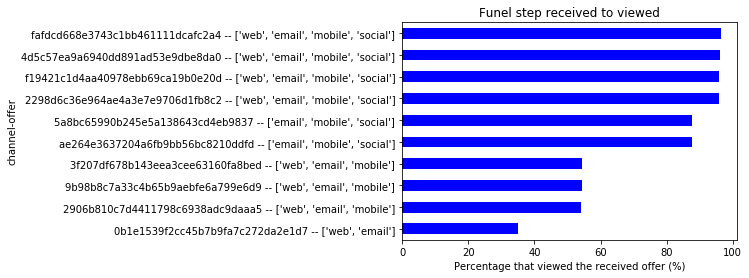

In [32]:
q06_funnel_performance['received_to_viewed_percentage'] = q06_funnel_performance['received_to_viewed']*100
q06_funnel_performance['channel-offer'] =  q06_funnel_performance['offer_id'] + ' -- ' + q06_funnel_performance['channels']
q06_funnel_performance.plot.barh(x='channel-offer',y='received_to_viewed_percentage', legend =False, color = 'blue' )
plt.xlabel('Percentage that viewed the received offer (%)')
plt.title('Funel step received to viewed')
plt.show()

The regressor has an r2 of 0.9999527246782942
The coeficients for the rate are [0.26588876 0.1932608  0.41827454 0.08373386], (email, mobile, social, web)


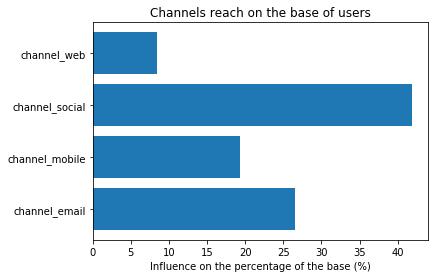

In [33]:
q06_channels = ['channel_email','channel_mobile','channel_social', 'channel_web']
q06_X = q06_funnel_performance.loc[:,q06_channels]
q06_y = q06_funnel_performance.loc[:,'received_to_viewed']
q06_view_rate_regressor = LinearRegression(fit_intercept=False).fit(q06_X, q06_y)
q06_pred = q06_view_rate_regressor.predict(q06_X)
q06_r2 = r2_score(q06_y,q06_pred)

print('The regressor has an r2 of {}'.format(q06_r2))
print('The coeficients for the rate are {}, (email, mobile, social, web)'.format(q06_view_rate_regressor.coef_))


x = q06_channels
y = q06_view_rate_regressor.coef_*100

fig, ax = plt.subplots()
ax.barh(x, width=y)
ax.set_xlabel('Influence on the percentage of the base (%)')
ax.set_title('Channels reach on the base of users')
plt.show()

<a name="Q07"></a>
**Q07.How is the funnel performance by offer?**

 - Since the influence on the view rate is based on the channel, lets focus the offer on the conversion rate from view to complete.
 - The metric of success for is the conversion from views to completed. "viewed_to_viewed_completed" (Remeber, we do not consider a success a completed offer without the view.)
 - The performance varies from 44% to 70% conversion.
 - Informational campaign does not have a completition, but the transaction are 41% and 44%. This means they are the botton performance campaigns.
 - BOGO offers seens slight less performatic than discounted ones.
 - Reward and difficulty does not seens to correlate to the conversion rate.
 - The transaction atribution is 2% to 8% less than the completition of the campaigns, because of the transactions with multiple campaigns. 

In [34]:
q07_columns = ['funnel__offer_received','funnel__offer_viewed','funnel__viewed_offer_completed',
               'funnel__viewed_transaction','funnel__transaction','funnel__offer_completed']
q07_funnel_performance = df_funnel.groupby(['offer_id_fix','offer_type','reward','difficulty'])[q07_columns].sum().reset_index()
q07_funnel_performance = q07_funnel_performance.fillna(0)


q07_funnel_performance['received_to_viewed']            = q07_funnel_performance['funnel__offer_viewed']           / q07_funnel_performance['funnel__offer_received']
q07_funnel_performance['viewed_to_transaction']         = q07_funnel_performance['funnel__transaction']            / q07_funnel_performance['funnel__offer_viewed']
q07_funnel_performance['viewed_to_viewed_transaction']  = q07_funnel_performance['funnel__viewed_transaction']     / q07_funnel_performance['funnel__offer_viewed']
q07_funnel_performance['received_to_transaction']       = q07_funnel_performance['funnel__transaction']            / q07_funnel_performance['funnel__offer_received']
q07_funnel_performance['viewed_to_completed']           = q07_funnel_performance['funnel__offer_completed']        / q07_funnel_performance['funnel__offer_viewed']
q07_funnel_performance['viewed_to_viewed_completed']    = q07_funnel_performance['funnel__viewed_offer_completed'] / q07_funnel_performance['funnel__offer_viewed']
q07_funnel_performance['received_to_completed']         = q07_funnel_performance['funnel__offer_completed']        / q07_funnel_performance['funnel__offer_received']

q07_funnel_performance['dif'] = q07_funnel_performance['viewed_to_viewed_completed'] - q07_funnel_performance['viewed_to_viewed_transaction']
q07_funnel_performance = q07_funnel_performance.sort_values(by='viewed_to_viewed_transaction')

q07_columns_02 = ['offer_id_fix','offer_type','reward','difficulty','viewed_to_viewed_transaction',
                  'viewed_to_viewed_completed','viewed_to_transaction','viewed_to_completed', 
                  'received_to_transaction','received_to_completed','dif']
q07_funnel_performance[q07_columns_02]

,offer_id_fix,offer_type,reward,difficulty,viewed_to_viewed_transaction,viewed_to_viewed_completed,viewed_to_transaction,viewed_to_completed,received_to_transaction,received_to_completed,dif
3,3f207df678b143eea3cee63160fa8bed,informational,0,0,0.413369,0.000000,0.413369,0.000000,0.224892,0.000000,-0.413369
4,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,0.421376,0.442124,0.432842,0.454682,0.415978,0.436967,0.020748
5,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0.443547,0.000000,0.443547,0.000000,0.389341,0.000000,-0.443547
7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,0.450540,0.481295,0.503918,0.545320,0.441966,0.478278,0.030756
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,20,0.508965,0.590560,1.020124,1.266740,0.356659,0.442881,0.081595
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,0.551932,0.570841,0.566868,0.588654,0.543984,0.564892,0.018909
2,2906b810c7d4411798c6938adc9daaa5,discount,2,10,0.605276,0.644844,0.881535,0.966667,0.476907,0.522963,0.039568
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,0.619852,0.651035,0.961914,1.036420,0.522904,0.563406,0.031183
1,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,7,0.649244,0.677066,0.668017,0.698811,0.640840,0.670381,0.027823
9,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10,0.651552,0.700642,0.665864,0.720037,0.642323,0.694581,0.049090


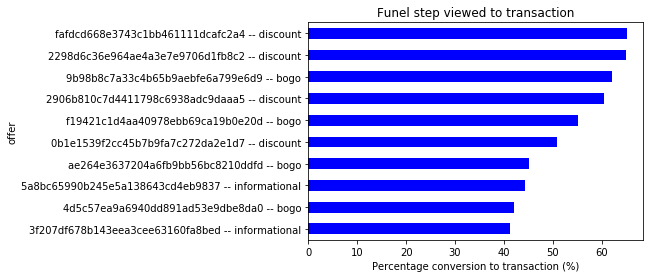

In [35]:
q07_funnel_performance['viewed_to_viewed_transaction_percentage'] = q07_funnel_performance['viewed_to_viewed_transaction']*100
q07_funnel_performance['offer'] =  q07_funnel_performance['offer_id_fix'] + ' -- ' + q07_funnel_performance['offer_type']
q07_funnel_performance.plot.barh(x='offer',y='viewed_to_viewed_transaction_percentage', legend =False, color = 'blue' )
plt.xlabel('Percentage conversion to transaction (%)')
plt.title('Funel step viewed to transaction')
plt.show()

<a name="discussion"></a>
### Discussion
---

Our goal is to recommend advertisiments to increase the botton line of the company. The effects of the offer are:
 1. it increase in transactions (new sales that would not happen)
 2. it increase in Average Ticket (more sales to trigger the discount)
 3. the cost of the offer (descrease of the average ticket with the dicounts)

Comparing below:
 - Using the informational campaign as a benchmark for natural sales, we can compare the normal level of sales against an offered one.
   - Using the [Q7](#Q07) above, adjusting the fact that informational offers has less duration time. We reach the conclusion that the amount of transaction does not increase for a discounted offer. So there is no increase on transactions.
 - Using the transactions with no offer as benchmark, we can compare the increase in the average ticket of each offer.
   - The results below show that transactions without offers had an average of **10.60**, informational offer had **11.80** and **14.90** while the discounted ones ranged from **17.20** to **25.05**. This means that offers in gereneral increase the average ticket of a person per transaction. Discounted one increse even more.
   - Since informational campaign have no visible cost associated with it, and they increase the average ticket, they are recommended.
   - Consider the the discounted offer with average ticket of 17.65 and discount of 5.00 (original price was 22.65) against the no offer. The botton line break even would be:
   <center>( Revenue - Cost ) in scenario 1 = ( Revenue - Cost ) in benchmark scenario</center>
   <center>17.65 - 22.65 * cost_of_product_rate = 10.60 - 10.60 * cost_of_product_rate</center>
   <center>17.65 - 10.60 = (22.65 - 10.60) * cost_of_product_rate</center>
   <center>cost_of_product_rate = (17.65 - 10.60)/(22.65 - 10.60)</center>
   <center>cost_of_product_rate = 58.5%</center>
   Any rate below that margin would make every offer type profitable by increase of average ticket alone. In my example I got a conservative example, since it has a low average ticket and a high discount.
   
Next steps:
 - considering that the increase in average ticket alone is enough to make this offers profitable, lets make an algorith to target the offer to user that has more chance of converting to it.
 - This algorith will use only user properties, so it does not suffer from cold start problem.


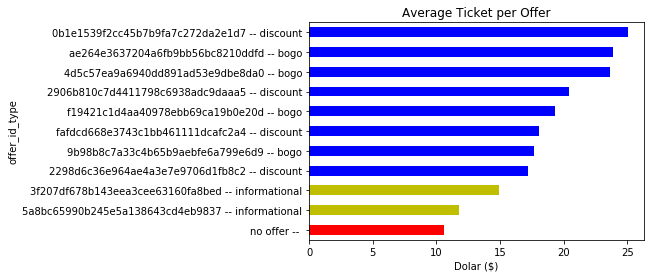

In [36]:
d01_df = df_events.copy()
d01_df['offer_type'] = d01_df['offer_type'].fillna('')
d01_df['offer_id_type'] = d01_df['offer_id_fix'] + ' -- ' + d01_df['offer_type']
d01_avg_ticket = d01_df[d01_df['event']=='transaction'].groupby(['offer_id_type']).agg({'amount':['sum'],'reward_expected':['sum'],'event':['count']}).reset_index()
d01_avg_ticket['average_ticket'] = d01_avg_ticket['amount']['sum'] / d01_avg_ticket['event']['count']
d01_avg_ticket['average_discount'] = d01_avg_ticket['reward_expected']['sum'] / d01_avg_ticket['event']['count']
d01_avg_ticket = d01_avg_ticket.sort_values(by='average_ticket').reset_index()

#d01_avg_ticket[['offer_id_type','average_ticket','average_discount']]
d01_avg_ticket.plot.barh(x='offer_id_type',y='average_ticket', legend = False, color=['r','y','y','b','b','b','b','b','b','b','b'])
plt.title('Average Ticket per Offer')
plt.xlabel('Dolar ($)')
plt.show()

In [37]:
d01_avg_ticket[['offer_id_type','average_ticket','average_discount']]

,offer_id_type,average_ticket,average_discount
,,,
0,no offer --,10.595284,0.0
1,5a8bc65990b245e5a138643cd4eb9837 -- informational,11.808152,0.0
2,3f207df678b143eea3cee63160fa8bed -- informational,14.903678,0.0
3,2298d6c36e964ae4a3e7e9706d1fb8c2 -- discount,17.212596,3.0
4,9b98b8c7a33c4b65b9aebfe6a799e6d9 -- bogo,17.655046,5.0
5,fafdcd668e3743c1bb461111dcafc2a4 -- discount,18.090014,2.0
6,f19421c1d4aa40978ebb69ca19b0e20d -- bogo,19.316108,5.0
7,2906b810c7d4411798c6938adc9daaa5 -- discount,20.442392,2.0
8,4d5c57ea9a6940dd891ad53e9dbe8da0 -- bogo,23.614922,10.0


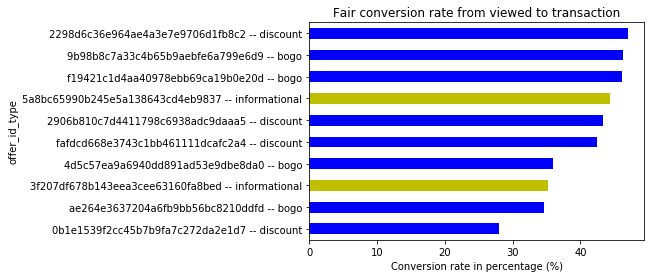

In [38]:
d02_minimum_campaign_duration = portfolio.duration.min()*24

d02_df = df_funnel[df_funnel['funnel__offer_viewed']==1][['id_user_offer','offer_type','offer_id_fix','time__offer_received','time__transaction']].copy()
d02_df['offer_id_type'] = d02_df['offer_id_fix'] + ' -- ' + d02_df['offer_type']
d02_df['min_time_transaction'] = (d02_df['time__transaction'] - d02_df['time__offer_received']).apply(lambda x: 1 if x <= d02_minimum_campaign_duration else 0)
d02_funnel_adjusted_performance = d02_df.groupby('offer_id_type').agg({'min_time_transaction':['sum'],'id_user_offer':['count']}).reset_index()
d02_funnel_adjusted_performance['fair_conversion_rate_percentage'] = 100*d02_funnel_adjusted_performance['min_time_transaction']['sum'] / d02_funnel_adjusted_performance['id_user_offer']['count']
d02_funnel_adjusted_performance = d02_funnel_adjusted_performance.sort_values(by='fair_conversion_rate_percentage').reset_index()

d02_funnel_adjusted_performance.plot.barh(x='offer_id_type',y='fair_conversion_rate_percentage',legend = False, color = ['b','b','y','b','b','b','y','b','b','b'])
plt.title('Fair conversion rate from viewed to transaction')
plt.xlabel('Conversion rate in percentage (%)')
plt.show()

In [39]:
d02_funnel_adjusted_performance

,index,offer_id_type,min_time_transaction,id_user_offer,fair_conversion_rate_percentage
,,,sum,count,
0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7 -- discount,767,2733,28.064398
1,7,ae264e3637204a6fb9bb56bc8210ddfd -- bogo,2344,6763,34.659175
2,3,3f207df678b143eea3cee63160fa8bed -- informational,1461,4144,35.255792
3,4,4d5c57ea9a6940dd891ad53e9dbe8da0 -- bogo,2630,7326,35.899536
4,9,fafdcd668e3743c1bb461111dcafc2a4 -- discount,3176,7476,42.482611
5,2,2906b810c7d4411798c6938adc9daaa5 -- discount,1807,4170,43.333333
6,5,5a8bc65990b245e5a138643cd4eb9837 -- informational,2966,6687,44.354718
7,8,f19421c1d4aa40978ebb69ca19b0e20d -- bogo,3364,7298,46.094820
8,6,9b98b8c7a33c4b65b9aebfe6a799e6d9 -- bogo,1943,4201,46.250893


<a name="groups"></a>
### Segmenting custormer to make the best suggestion of offer 
---
This part is to define which offer works with each of those groups!

Making more investigation on data information:

age had 9828 nulls


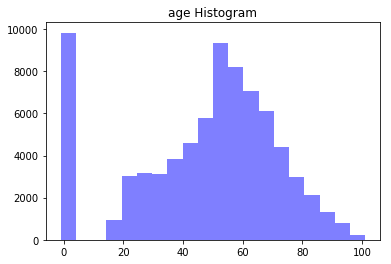

income had 9828 nulls


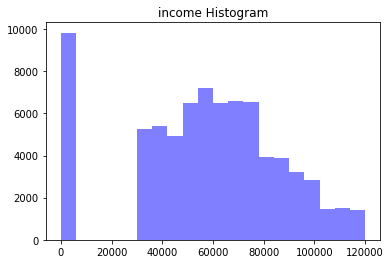

days_as_member had 0 nulls


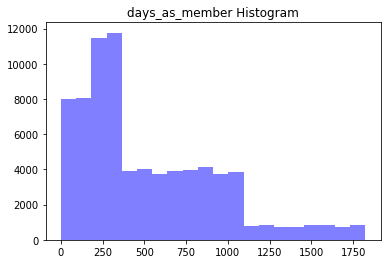

gender had 9828 nulls


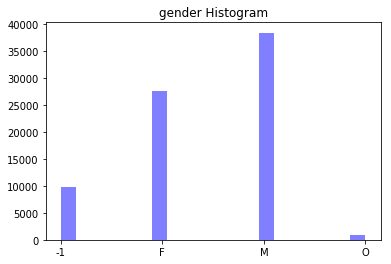

In [40]:
for each in ['age','income','days_as_member','gender']:
    print(each + ' had ' + str(df_funnel[each].isna().sum()) + ' nulls')
    x = df_funnel[each].fillna(-1)
    plt.title('{} Histogram'.format(each))
    plt.hist(x, 20, facecolor='blue', alpha=0.5)
    plt.show()

**There is some kind of sing-up in the starbucks that does not require personal information like age, income and gender. Since they always happen at same time**

In [41]:
number_of_missing_infos = df_funnel[(df_funnel['age'].isna()) & (df_funnel['income'].isna()) & (df_funnel['gender'].isna())].shape[0]
number_of_missing_infos

9828

In [42]:
def create_models(offer_type = OFFER_TYPES, df_funnel = df_funnel, scaler = True):
    ''' This function create a dataframe of models and its performance metrics
    INPUT
        offer_type (List[Strings])  - List with types of offer to create the model for
        df_funnel (Dataframe)
        scaler (Boolean) To use standard scaler in the model
    OUTPUT
        model_results (Dataframe) - Metrics and models in a dataframe.
        model_input (List[Strings]) - The list of inputs the model asks for.
    '''
    models = []
    models_columns = ['offer_type','model_type','fscore','roc','precision','recall',
                      'true-negative','false-negative','false-positive','true-positive','model']
    for each_offer_type in offer_type:
        model_input = ['age','days_as_member','income','user_info_missing']
        model_output = 'funnel__transaction' if each_offer_type == 'informational' else 'funnel__offer_completed'
        
        # Data Treatment
        filtering_rows = (df_funnel['funnel__offer_viewed']==1) & (df_funnel['offer_type']==each_offer_type)
        df_model = df_funnel[filtering_rows].copy().sort_values(by=model_output, ascending=False)
        df_model['age'] = df_model['age'].fillna(df_model['age'].mean())
        df_model['income'] = df_model['income'].fillna(df_model['income'].mean())
        df_model['gender'] = df_model['gender'].fillna('unknown')
        enc = OneHotEncoder()
        df_model = pd.get_dummies(df_model, columns = ['gender'], prefix = 'gender_')
        for each in ['gender__F','gender__M','gender__O']:
            model_input.append(each)
        df_model = df_model.drop('gender__unknown', axis = 1)
        
        # Data separation
        X = df_model.loc[:,model_input]
        y = df_model.loc[:,model_output]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Declaring models
        model_DecisionTreeClassifier = DecisionTreeClassifier( max_depth=6, min_samples_leaf=50, min_impurity_decrease = 0.01)
        model_LogisticRegression = LogisticRegression()
        model_GaussianNB = GaussianNB()
        
        # Training models
        for model,name in [(model_DecisionTreeClassifier,'DecisionTreeClassifier')
                          ,(model_LogisticRegression,'LogisticRegression')
                          ,(model_GaussianNB,'GaussianNB')]:
            
            # Data standard
            if scaler and not name == 'DecisionTreeClassifier':
                scaler = StandardScaler()
                X_train_std = scaler.fit_transform(X_train)
                X_test_std = scaler.transform(X_test)
            else:
                X_train_std = X_train
                X_test_std = X_test
            
            model.fit(X_train_std,y_train)
        
            # Perfomance metrics         
            y_pred = model.predict(X_test_std)
            cm = confusion_matrix(y_test, y_pred)
            roc = roc_auc_score(y_test, y_pred)
            precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

            # Storing Results
            models.append([each_offer_type,name,fscore[1],roc,precision[1],recall[1],cm[0][0],cm[1][0],cm[0][1],cm[1][1], model])
    
    model_results = pd.DataFrame(models,columns = models_columns).sort_values(by='fscore', ascending = False)
    return(model_results, model_input)

In [43]:
df_models, model_input = create_models()
df_models

,offer_type,model_type,fscore,roc,precision,recall,true-negative,false-negative,false-positive,true-positive,model
6,discount,DecisionTreeClassifier,0.835188,0.644105,0.743706,0.952332,484,139,957,2777,"DecisionTreeClassifier(max_depth=6, min_impuri..."
8,discount,GaussianNB,0.835188,0.644105,0.743706,0.952332,484,139,957,2777,GaussianNB()
7,discount,LogisticRegression,0.832135,0.671923,0.764503,0.912894,621,254,820,2662,LogisticRegression()
2,bogo,GaussianNB,0.740778,0.690954,0.676570,0.818451,1363,490,1056,2209,GaussianNB()
1,bogo,LogisticRegression,0.725114,0.688018,0.685828,0.769174,1468,623,951,2076,LogisticRegression()
0,bogo,DecisionTreeClassifier,0.632521,0.687951,0.797968,0.523898,2061,1285,358,1414,"DecisionTreeClassifier(max_depth=6, min_impuri..."
3,informational,DecisionTreeClassifier,0.550753,0.575085,0.514986,0.591858,675,391,534,567,"DecisionTreeClassifier(max_depth=6, min_impuri..."
5,informational,GaussianNB,0.357939,0.542736,0.537657,0.268267,988,701,221,257,GaussianNB()
4,informational,LogisticRegression,0.337455,0.544576,0.556355,0.242171,1024,726,185,232,LogisticRegression()


Decision Tree Classifeir for discount


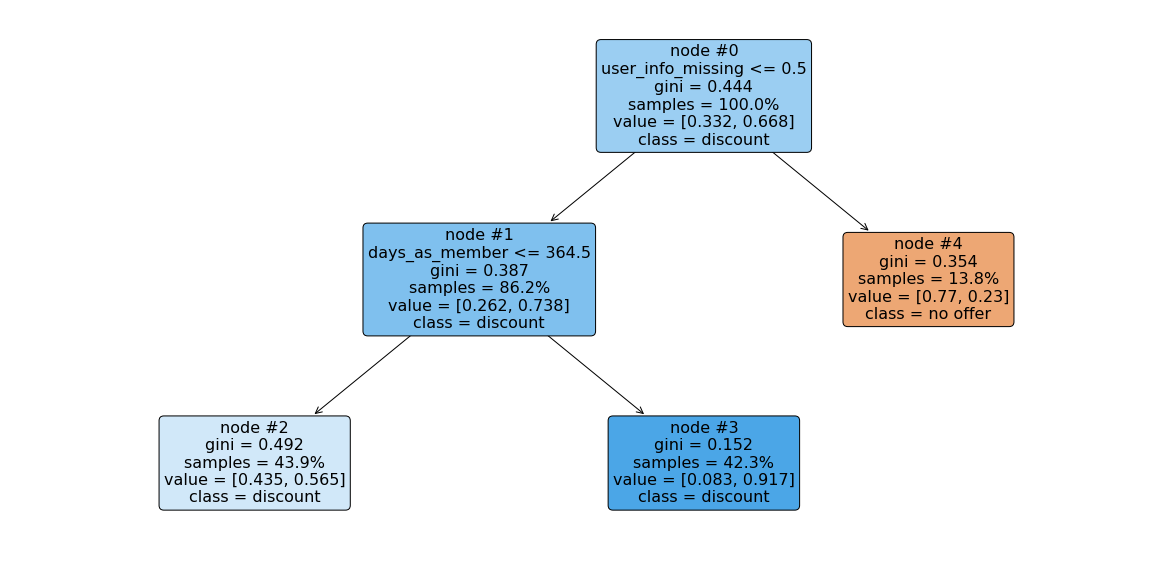

Decision Tree Classifeir for bogo


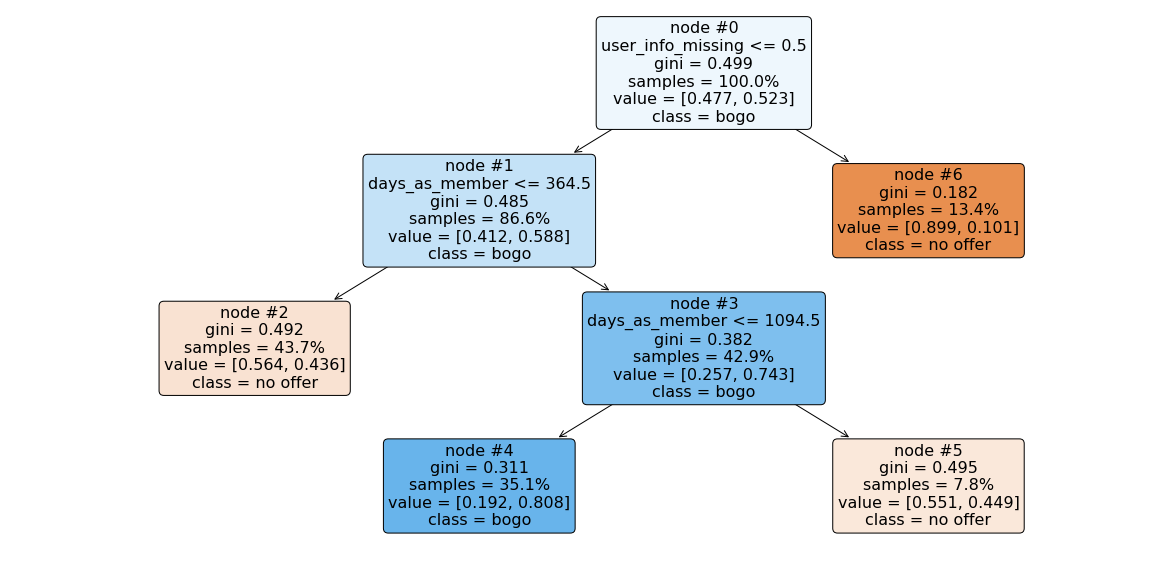

Decision Tree Classifeir for informational


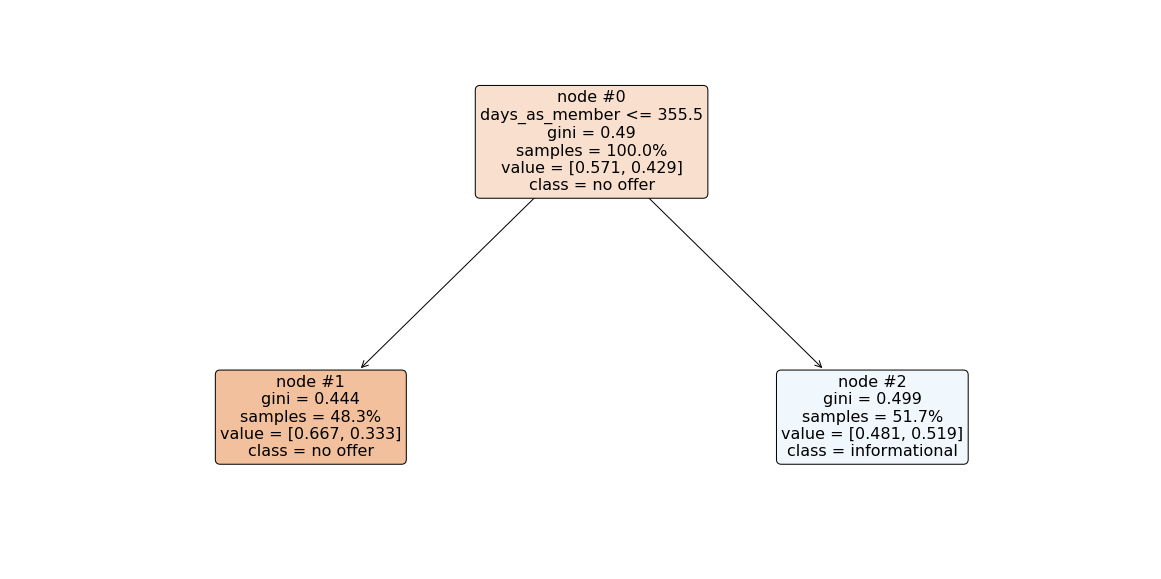

In [44]:
# plot trees
for index, row in df_models[df_models['model_type']=='DecisionTreeClassifier'].iterrows():
    plt.figure(figsize = (20,10))
    print('Decision Tree Classifeir for {}'.format(row['offer_type']))
    plot_tree_results = plot_tree(row['model'], 
                                  feature_names = model_input,
                                  class_names = ['no offer',row['offer_type']],
                                  proportion = True,
                                  filled = True,
                                  node_ids = True,
                                  rounded = True,
                                  fontsize = 16
                                 )
    plt.show()

#### From the trees, we identify the following segments.
 - group 1: missing infos.
 - group 2: User in its first year
 - group 3: User in its second or third year
 - group 4: User is in its fourth or more years

In [45]:
def user_clustering(user_info_missing ,days_as_meber):
    ''' This creates the cluster that the classification tree identified
    input: 
        user_info_missing (int) 1:Info is missing for user 0:User has infos
        days_as_member - days that the client has been mender of starbucks
    '''
    cluster = 'none'
    if user_info_missing == 1:
        cluster = '01_missing_infos'
    elif days_as_meber < 365:
        cluster = '02_first_year'
    elif days_as_meber < 1095:
        cluster = '03_second_third_year'
    else:
        cluster = '04_older_user'
    return(cluster)

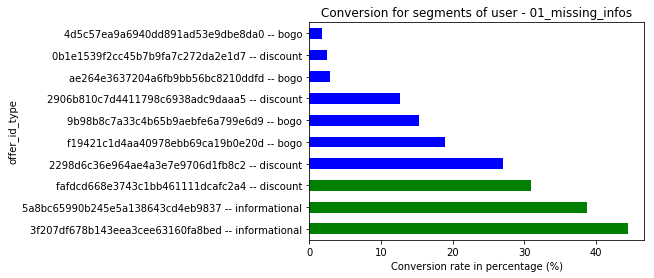

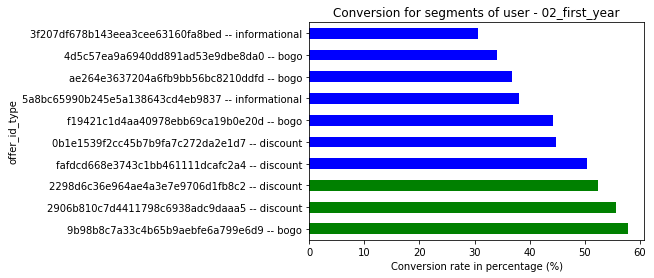

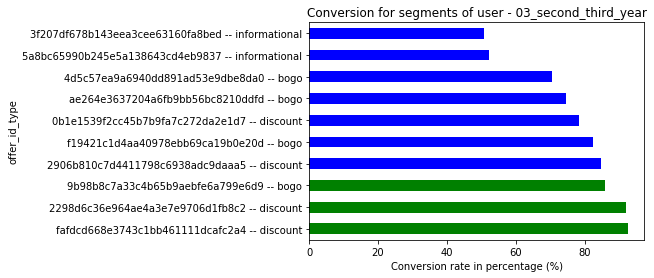

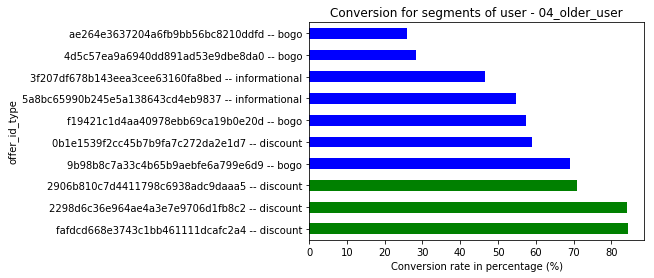

In [46]:
df_results = df_funnel[df_funnel['funnel__offer_viewed']==1][['id_user_offer','offer_id_fix','offer_type','funnel__transaction','user_info_missing','days_as_member']].copy()
cluster = []
for index, row in df_results.iterrows():
    cluster.append(user_clustering(row['user_info_missing'],row['days_as_member']))
df_results['cluster'] = cluster
df_results['offer_id_type'] = df_results['offer_id_fix'] + ' -- ' + df_results['offer_type']

df_results_grouped = df_results.groupby(['cluster','offer_id_type']).agg({'id_user_offer':['count'],'funnel__transaction':['sum']}).reset_index()
df_results_grouped['conversion'] = 100*df_results_grouped['funnel__transaction']['sum']/df_results_grouped['id_user_offer']['count']
df_results_grouped = df_results_grouped.sort_values(by=['cluster','conversion'], ascending=[True,False])

for each in list(df_results_grouped['cluster'].unique()):
    df_results_grouped[df_results_grouped['cluster']==each].plot.barh(x='offer_id_type',y='conversion',legend = False, color = ['g','g','g','b','b','b','b','b','b','b'])
    plt.title('Conversion for segments of user - {}'.format(each))
    plt.xlabel('Conversion rate in percentage (%)')
    plt.show()


In [47]:
df_results_grouped

,cluster,offer_id_type,id_user_offer,funnel__transaction,conversion
,,,count,sum,
3,01_missing_infos,3f207df678b143eea3cee63160fa8bed -- informational,657,292.0,44.444444
5,01_missing_infos,5a8bc65990b245e5a138643cd4eb9837 -- informational,814,315.0,38.697789
9,01_missing_infos,fafdcd668e3743c1bb461111dcafc2a4 -- discount,942,292.0,30.997877
1,01_missing_infos,2298d6c36e964ae4a3e7e9706d1fb8c2 -- discount,967,261.0,26.990693
8,01_missing_infos,f19421c1d4aa40978ebb69ca19b0e20d -- bogo,959,181.0,18.873827
6,01_missing_infos,9b98b8c7a33c4b65b9aebfe6a799e6d9 -- bogo,675,103.0,15.259259
2,01_missing_infos,2906b810c7d4411798c6938adc9daaa5 -- discount,665,84.0,12.631579
7,01_missing_infos,ae264e3637204a6fb9bb56bc8210ddfd -- bogo,815,24.0,2.944785
0,01_missing_infos,0b1e1539f2cc45b7b9fa7c272da2e1d7 -- discount,448,11.0,2.455357


<a name="decisions"></a>
### Business Decisions
---

 1. First, use all channels in the campaigns.
   - By not using all the channels, we are giving discount aways without increase the number of sales. 
   - One important observation: we should use all channels if costless and not excessive on content for the users. 
 2. Second, we should make campaigns since they increase the average ticket of a sale.
   - This is invalid if the cost per product is higher than the thershold calculate before.
 3. For the four segments described. I am chossing the top performance campaigns of each subgroup.
    - group 1: missing infos.
      - Works best with informational campaigns, and can be a target of some kinds of discount campaigns.
      - Conversion of top three goes from 30% to 44%. Has the lowest conversion of the subgroups.
        - informational: 3f207df678b143eea3cee63160fa8bed
        - informational: 5a8bc65990b245e5a138643cd4eb9837 
        - discount: fafdcd668e3743c1bb461111dcafc2a4	
    - group 2: User in its first year
      - Works best with discounted campaigns, and an outlier BOGO campaign.
      - Conversion of top three goes from 52% to 57%.
        - bogo: 9b98b8c7a33c4b65b9aebfe6a799e6d9
        - discount: 2906b810c7d4411798c6938adc9daaa5
        - discount: 2298d6c36e964ae4a3e7e9706d1fb8c2
    - group 3: User in its second or third year
      - Works best with discounted campaigns, and has an ok performance with specific BOGO campaign.
      - Conversion of top three goes from 85% to 92%. This conversion truly high.
        - discount: fafdcd668e3743c1bb461111dcafc2a4
        - discount: 2298d6c36e964ae4a3e7e9706d1fb8c2
        - bogo: 9b98b8c7a33c4b65b9aebfe6a799e6d9
    - group 4: User is in its fourth or more years
      - Works best with discounted campaigns.
      - Conversion of top three goes from 70% to 84%.
        - discount: fafdcd668e3743c1bb461111dcafc2a4
        - discount: 2298d6c36e964ae4a3e7e9706d1fb8c2
        - discount: 2906b810c7d4411798c6938adc9daaa5